In [13]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as K
import tensorflow as tf
from src.models.train_model import train_svm
from src.models.detectors import Detector
from tqdm import tqdm
from copy import deepcopy
from src.data.dataset_loaders import DatasetLoader, AerialCarsDatasetLoader
from typing import Tuple, List, Set, Any
from src.features.pipelines import RawImageToFeatures
from src.features.processors import NormImage, Resize
from src.data.image_loaders import AerialCarsFixedSizeImageLoader
from src.models.classifiers import ResnetModelWrapper
from src.models.detectors import SliderDetector, SliderProbDetector
from src.data.sliders import SlidingWindow
from src.features.processors import RotateToHorizontal, Resize
from src.features.descriptors import HOGDescriptor, LBPDescriptor
import matplotlib.pyplot as plt
from src.models.classifiers import ProbSVMModelWrapper
import cv2

# Aerial-Cars-Dataset
# SVM Experiment

### Data loading

In [2]:
DATA_PATH = '../../../data/processed/aerial-cars-dataset/svm/data_svm.pickle'

In [3]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

### SVM trainig

In [4]:
model, report = train_svm(data, test_size=0.2, probability=True)

In [5]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.98      1.00      0.99        59

    accuracy                           0.99       111
   macro avg       0.99      0.99      0.99       111
weighted avg       0.99      0.99      0.99       111



### Validation

In [31]:
def validate_model(
        dataset_loader: DatasetLoader,
        input_folder_filepath: str,
        images_files_types: Tuple[str],
        annotations_files_types: Tuple[str],
        detector: Detector,
        output_folder_filepath: str,
        workers: int = 0,
        iou_threshold=0.5
):
    images = dataset_loader.load_dataset(
        input_folder_filepath,
        images_files_types,
        annotations_files_types,
        False
    )

    processed_images = []

    for image in tqdm(images):
        processed_images.append(
            detector(deepcopy(image), workers)
        )

    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for id, processed_image in enumerate(processed_images):
        image_array, pred_bnd_boxes, image = processed_image
        tp, fp = evaluate_image(image, pred_bnd_boxes, iou_threshold)
        true_positives += tp
        false_positives += fp
        false_negatives += (len(image.bnd_boxes) - tp)
        
        image_filename = f'prediction_output_{id}.jpg'
        output_full_path = output_folder_filepath + '/' + image_filename
        image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_full_path, image_array)
        

    return true_positives, false_positives, false_negatives, processed_images

In [14]:
def evaluate_image(
        image,
        pred_bnd_boxes: List[Set[float]],
        iou_threshold: float
) -> Tuple[Any, Any]:
    true_bnd_boxes = image.bnd_boxes

    tps = np.zeros(len(pred_bnd_boxes))
    fps = np.zeros(len(pred_bnd_boxes))

    from collections import Counter
    repeats_counter = Counter()

    for idp, pred_box in enumerate(pred_bnd_boxes):
        pred_max_iou = 0
        best_true_matched = -1
        for idt, true_box in enumerate(true_bnd_boxes):
            iou = intersection_over_union(pred_box, true_box)
            if iou > pred_max_iou:
                pred_max_iou = iou
                best_true_matched = idt
        if pred_max_iou >= iou_threshold:
            if repeats_counter[best_true_matched] == 0:
                tps[idp] = 1
                repeats_counter[best_true_matched] = 1
            else:
                fps[idp] = 1
        else:
            fps[idp] = 1

    tp = np.sum(tps)
    fp = np.sum(fps)

    return tp, fp 

In [15]:
BND_BOX_SIZE = (80, 80)

dataset_loader = AerialCarsDatasetLoader(
    image_loader=AerialCarsFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline = RawImageToFeatures(
    processors=[],
    descriptors=[
        HOGDescriptor(
            orientations = 9,
            cells_per_block = (2, 2),
            pixels_per_cell = (4, 4),
            multichannel = True,
            visualize = True
        ),
        LBPDescriptor(
            bins = 256,
            range = (0, 256)
        )
    ]
)

sliding_window = SlidingWindow(
    step_size=20,
    window_size=BND_BOX_SIZE
)

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ProbSVMModelWrapper(model),
    treshold=0.8,
    nms_overlap=0.4
)

In [32]:
true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath='../../../data/raw/aerial-cars-dataset/val_dev',
    output_folder_filepath='../../../data/processed/aerial-cars-dataset/val_dev',
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=7
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:27<00:00, 327.59s/it]

38
Overlap is 0.7530864197530864
Overlap is 0.7530864197530864
Overlap is 0.7530864197530864
Overlap is 0.7530864197530864
Overlap is 0.25925925925925924
Overlap is 0.012345679012345678
Overlap is 0.25925925925925924
Overlap is 0.5061728395061729
Overlap is 0.13122999542752628
Overlap is 0.7530864197530864
Overlap is 0.003200731595793324
Overlap is 0.7530864197530864
Overlap is 0.003200731595793324
Overlap is 0.7530864197530864
Overlap is 0.7530864197530864
Overlap is 0.25925925925925924
Overlap is 0.009297363206828228
Overlap is 0.7530864197530864
Overlap is 0.5061728395061729
Overlap is 0.5061728395061729
Overlap is 0.19524462734339276
Overlap is 0.5061728395061729
25


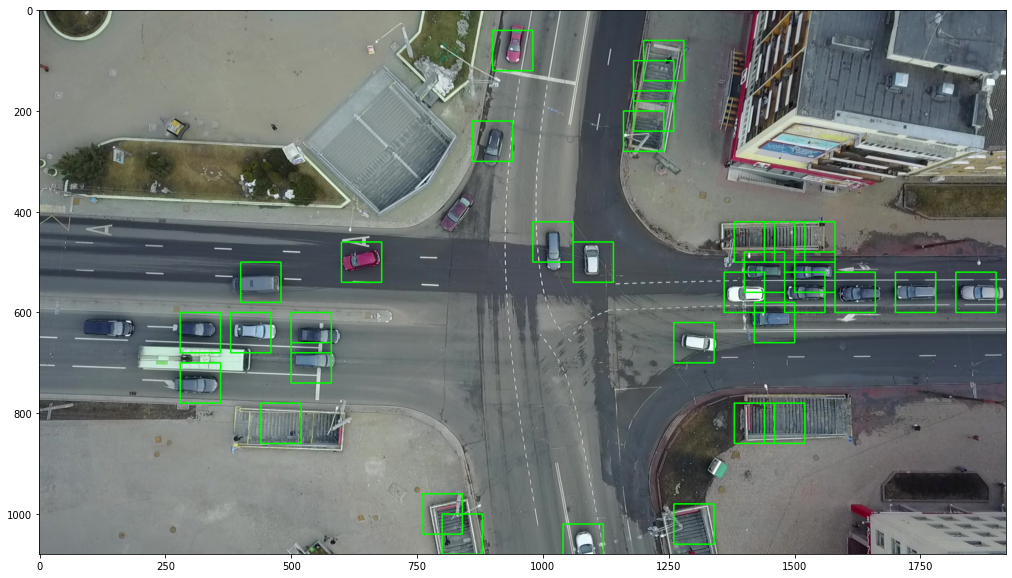

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(processed_images[0][0])

In [ ]:
def is_intersecting(box1, box2) -> bool:
    box1_xtl = box1[4]
    box1_ytl = box1[5]
    box1_xbr = box1[2]
    box1_ybr = box1[3]

    box2_xtl = box2[4]
    box2_ytl = box2[5]
    box2_xbr = box2[2]
    box2_ybr = box2[3]

    if box1_xtl > box2_xbr:
        return False  # boxA is right of boxB
    if box2_xtl > box1_xbr:
        return False  # boxA is left of boxB
    if box1_ybr < box2_ytl:
        return False  # boxA is above boxB
    if box1_ytl > box2_ybr:
        return False  # boxA is below boxB
    return True


def get_intersection_area(box1, box2) -> float:
    box1_xtl = box1[4]
    box1_ytl = box1[5]
    box1_xbr = box1[2]
    box1_ybr = box1[3]

    box2_xtl = box2[4]
    box2_ytl = box2[5]
    box2_xbr = box2[2]
    box2_ybr = box2[3]

    xtl = max(box1_xtl, box2_xtl)
    ytl = max(box1_ytl, box2_ytl)
    xbr = min(box1_xbr, box2_xbr)
    ybr = min(box1_ybr, box2_ybr)
    # intersection area
    return (xbr - xtl + 1) * (ybr - ytl + 1)


def area(box) -> float:
    xtl = box[4]
    ytl = box[5]
    xbr = box[2]
    ybr = box[3]
    return (xbr - xtl + 1) * (ybr - ytl + 1)


def get_union_areas(box1, box2, intersection_area: float = None) -> float:
    if intersection_area is None:
        intersection_area = get_intersection_area(box1, box2)
    return float(area(box1) + area(box2) - intersection_area)


def intersection_over_union(box1, box2) -> float:
    """
    Intersection Over Union (IOU) is measure based on Jaccard Index that evaluates the overlap between
    two bounding boxes.
    """
    # if boxes dont intersect
    if not is_intersecting(box1, box2):
        return 0
    intersection = get_intersection_area(box1, box2)
    union = get_union_areas(box1, box2, intersection_area=intersection)
    # intersection over union
    iou = intersection / union
    assert iou >= 0, '{} = {} / {}, {}, {}'.format(iou, intersection, union, box1, box2)
    return iou


def precision(tp: float, fp: float) -> float:
    return tp / (tp + fp)


def recall(tp: float, fn: float) -> float:
    return tp / (tp + fn)


def f1_score(tp: float, fp: float, fn: float) -> float:
    return tp / (tp + 0.5*(fp + fn))